# Processing SAR (Synthetic Aperture Radar) data to TileDB arrays:
### using TileDB in combination with GDAL and Rasterio

Synthetic Aperture Radar - or SAR - is a type of remote sensing (satellite earth imaging) that works by measuring energy reflected back from a surface. It is especially good at detecting complex structures. 

Let's say you have a complicated set of skyscrapers with different heights and shapes in a city center, SAR could be a good way to capture a lot of the detail there.

In this notebook, we will:
  - Download SAR images in Goereferenced TIFF (GeoTIFF) format (this format works well with GDAL and Rasterio).
  - Use the TileDB Writer for GDAL to write them to a TileDB array for storage/access. [(GDAL TileDB Driver)](https://github.com/OSGeo/gdal/blob/master/gdal/frmts/tiledb/tiledbdataset.cpp)
  - Use the TileDB Reader for Rasterio to open, read, and transform that TileDB array in a way we can then easily visualize as an image. [(Rasterio TileDB Driver - not sure???????)]()

Note: the data used here is openly licensed from the Spacenet 6 challenge.

First, let's prepare some of the GIS and data handling/visualization tools we'll be using.

GDAL and Rasterio should both already be in the active environment from the earlier set-up, so we'll just bring in the parts we'll need in the Python code.

In [49]:
import json
from matplotlib import pyplot
import numpy as np
import rasterio
from rasterio.plot import (
    show,
    reshape_as_raster,
    reshape_as_image,
    adjust_band
)
from rasterio.warp import transform_bounds
from rasterio.windows import Window
from rasterio.crs import CRS
import shutil

Now, we'll download two SAR GeoTIFF images from the publicly available Spacenet aws s3 storage.

The images we're getting are over Rotterdam in Amsterdam. 

Note about the image contents:

They have a resolution of 0.25m and contain 6 bands: 
  - 4 SAR Intensity Bands:
    - 1: HH , 2: HV, 3: VH, 4: VV

  - 2 additional channels related to bounced backscatter (beyond the this exercise scope):
    - 5: alpha² & 6: beta²

For our purposes, we'll be using:
    Red = 1: HH Intensity, Green = 4: VV Intensity, Blue = 2: HV Intensity
 
For more on SAR data: [NASA Earthdata](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar)  
For more on Spacenet's SAR image bands: [Spacenet Medium Article](https://medium.com/the-downlinq/spacenet-6-expanded-dataset-release-e1a7ddaf030)

In [137]:
import os

# image_1 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804111224_20190804111453.tif"
image_1 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804111224_20190804111453.tif"
image_2 = "SN6_AOI_11_Rotterdam_SAR-MAG-POL_20190804113009_20190804113242.tif"

if not os.path.exists("tmp"):
    os.mkdir("tmp")

for image in (image_1, image_2):
    if not os.path.exists(f"./tmp/{image}"):
        !aws s3 cp s3://spacenet-dataset/AOIs/AOI_11_Rotterdam/SAR-MAG-POL/$image ./tmp/

# rename the image data files
image_1 = f"./tmp/{image_1}"
image_2 = f"./tmp/{image_2}"

You should see an output counter with the progress of the two image downloads. Please wait for both to complete. 

Note: these might take awhile, if they aren't done and you still want to code along, you can use the corresponding smaller images stored in a local folder. Just run the cell immediately below this one.

In [71]:
# Note: DO NOT RUN IF YOU ALREADY HAVE THE LARGER IMAGES

image_1 = "../data/SAR_images/image_1.tif"
image_2 = "../data/SAR_images/image_2.tif"

Let's use rasterio to get some more details about these two georeferenced images. 

In [117]:
!rio info $image_1 | jq .
!rio info $image_2 | jq .

{
  "bounds": [
    592317.4837528648,
    5749201.311398174,
    602997.4837528648,
    5749906.311398174
  ],
  "colorinterp": [
    "gray",
    "undefined",
    "undefined",
    "undefined",
    "undefined",
    "undefined"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "GTiff",
  "dtype": "float32",
  "height": 141,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "pixel",
  "lnglat": [
    4.41903215452312,
    51.88818738825498
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    5,
    5
  ],
  "shape": [
    141,
    2136
  ],
  "tiled": false,
  "transform": [
    5,
    0,
    592317.4837528648,
    0,
    -5,
    5749906.311398174,
    0,
    0,
    1
  ],
  "units": [
    null,
    nul

We can also parse the info and extract the image bounds.

Note: the bounds are entered in this order: 

Left, Bottom, Right, Top

In [124]:
image_1_info = !rio info $image_1
image_2_info = !rio info $image_2
image_1_info, image_2_info = json.loads(image_1_info[0]), json.loads(image_2_info[0])
image_1_bds = image_1_info["bounds"]
image_2_bds = image_2_info["bounds"]
print(f"image_1_bounds: {image_1_bds}\nimage_2_bounds: {image_2_bds}")

image_1_bounds: [592317.4837528648, 5749201.311398174, 602997.4837528648, 5749906.311398174]
image_2_bounds: [592283.6673783489, 5749730.521989683, 603273.6673783489, 5750440.521989683]


Just for ease-of-use, we'll switch those over to latitude/longitude units.

In [125]:
image_1_bounds = transform_bounds(image_1_info["crs"], CRS.from_epsg(4326), *image_1_bds)
image_2_bounds = transform_bounds(image_2_info["crs"], CRS.from_epsg(4326), *image_2_bds)
print(f"image_1_bounds lat/lon: {image_1_bounds}\nimage_2_bounds lat/lon: {image_2_bounds}")

image_1_bounds lat/lon: (4.341367478972798, 51.88405802655791, 4.496703535807708, 51.8922658443726)
image_2_bounds lat/lon: (4.3410178618831745, 51.88876350543979, 4.500875385958219, 51.89707327920041)


Now we'll take both of those images, mosaic them with GDAL's buildvrt, and then write and store them in a TileDB array using the TileDB writer plugin for GDAL.

In [138]:
output_array = "arrays/sar_output_array"

# clean up previous runs
try:
    shutil.rmtree(output_array)
except:
    pass

!gdalbuildvrt mosaic.vrt $image_1 $image_2
!gdal_translate -OF TileDB -CO BLOCKXSIZE=1024 -CO BLOCKYSIZE=1024 -CO COMPRESSION=ZSTD -CO COMPRESSION_LEVEL=7 mosaic.vrt $output_array

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 43971, 4966
0...10...20...30...40...50...60...70...80...90...100 - done.


Now let's take a look at the info on our output array. (Note how rasterio's `rio` function is able to process georeferenced files in TileDB format.)

In [127]:
!rio info $output_array | jq .

{
  "blockxsize": 1024,
  "blockysize": 1024,
  "bounds": [
    592283.6673783489,
    5749200.521989683,
    603273.6673783489,
    5750440.521989683
  ],
  "colorinterp": [
    "red",
    "green",
    "blue",
    "alpha",
    "alpha",
    "alpha"
  ],
  "count": 6,
  "crs": "EPSG:32631",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "TileDB",
  "dtype": "float32",
  "height": 248,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "interleave": "band",
  "lnglat": [
    4.420868063671239,
    51.89056343616332
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": null,
  "res": [
    5,
    5
  ],
  "shape": [
    248,
    2198
  ],
  "tiled": true,
  "transform": [
    5,
    0,
    592283.6673783489,
    0,
    -5,
    5750440.521989683,
    0,
    0,
    1
  ],
  "units

Once again, we'll parse that info to get the mosaic's bounds. And, we'll then transform it to latitude/longitude.

In [129]:
output_info = !rio info $output_array
output_info = json.loads(output_info[0])
output_bds = output_info["bounds"]
print(f"output_bounds: {output_bds}\n")
output_bounds = transform_bounds(output_info["crs"], CRS.from_epsg(4326), *output_bds)
print(f"output_bounds lat/lon: {output_bounds}")

output_bounds: [592283.6673783489, 5749200.521989683, 603273.6673783489, 5750440.521989683]

output_bounds lat/lon: (4.3408760632540355, 51.88399984073367, 4.500875385958219, 51.89707327920041)



For the final step, we'll open back up the geo-images we just wrote to a TileDB array.

Using the standard `rasterio.open`, the TileDB Reader plugin is called and integrates the output easily with the other raster formats used with rasterio.

Note: TileDB storage is optimized for 'windowed' reading, so you can query just what you need, without downloading any unneccessary data. You can see this below in the `bbox` we used which integrates easily with `rasterio.Window` to get only a part of the image. It works behind the scenes so you don't even need to know it's there.

We've set up a function that opens and shows a window within the mosaic output array.

So, we just need to choose what area within the output bounds we want to look at.

Here are the bounds:

In [130]:
output_bounds

(4.3408760632540355, 51.88399984073367, 4.500875385958219, 51.89707327920041)

And we'll pick this area, for illustration purposes:

In [142]:
lat_lon_bbox = [4.34, 51.885, 4.36, 51.897]

window shape: (3, 4966, 5272)



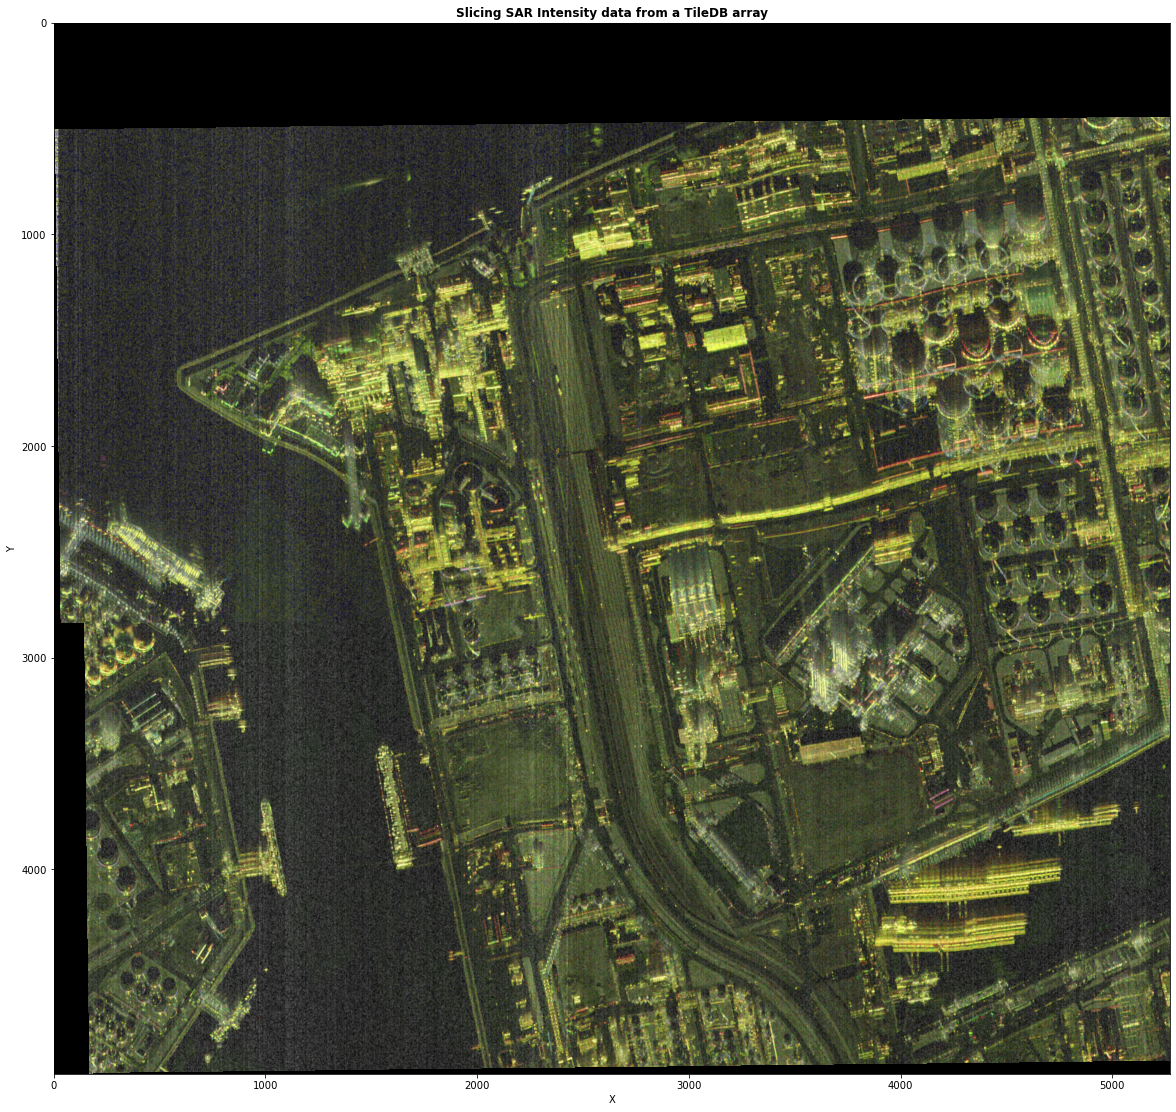

In [140]:
with rasterio.Env():
    with rasterio.open(output_array) as src:
        # query dataset in lat/lon coordinates
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

        img = src.read((1, 4, 2), window=bounds_window)
        print(f"window shape: {img.shape}\n")

        arr = reshape_as_raster(img)
        for b, band in enumerate(arr):
            arr[b] = adjust_band(band)
        arr = reshape_as_image(arr)

        fig, ax = pyplot.subplots(1, 1, figsize=(20, 20))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        show(arr, ax=ax, title="Slicing SAR Intensity data from a TileDB array")

You can try it with your own lat/lon window and see what images you get. Just set `lat_lon_bbox` to a list/tuple of bounds in the order [Left, Bottom, Right, Top] and then rerun the cell above.

In [ ]:
lat_lon_bbox = ["enter custom lat/lon bbox here"]

In the function above, we extracted bands 1: HH, 4: VV, and 2: HV for red, green, blue in the output image.
You can see this in the src.read(...) in `show_lat_lon_window` above.

Other bands in these SAR images that can give a lot of info abount structures are:

alpha², beta², and gamma²

From the image bands above:
- 5: alpha², 6: beta²
- gamma² = 2 * HV (2 above)

Try editing the function above to construct an image with alpha, beta, gamma bands.

In [ ]:
lat_lon_bbox = [4.34, 51.885, 4.36, 51.897]

In [150]:
def get_gamma_sq(lat_lon_bbox):
    with rasterio.Env():
        with rasterio.open(output_array) as src:
            # query dataset in lat/lon coordinates
            native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
            bounds_window = src.window(*native_bounds)
            bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

            img = src.read((2,), window=bounds_window)
            arr = reshape_as_raster(img)
            for b, band in enumerate(arr):
                for i in range(len(arr[b])):
                    arr[b][i] *= 2
                band = arr[b]
                arr[b] = adjust_band(band)
            arr = reshape_as_image(arr)
            return arr

In [153]:
gamma2 = get_gamma_sq(lat_lon_bbox)

window shape: (2, 4966, 5272)



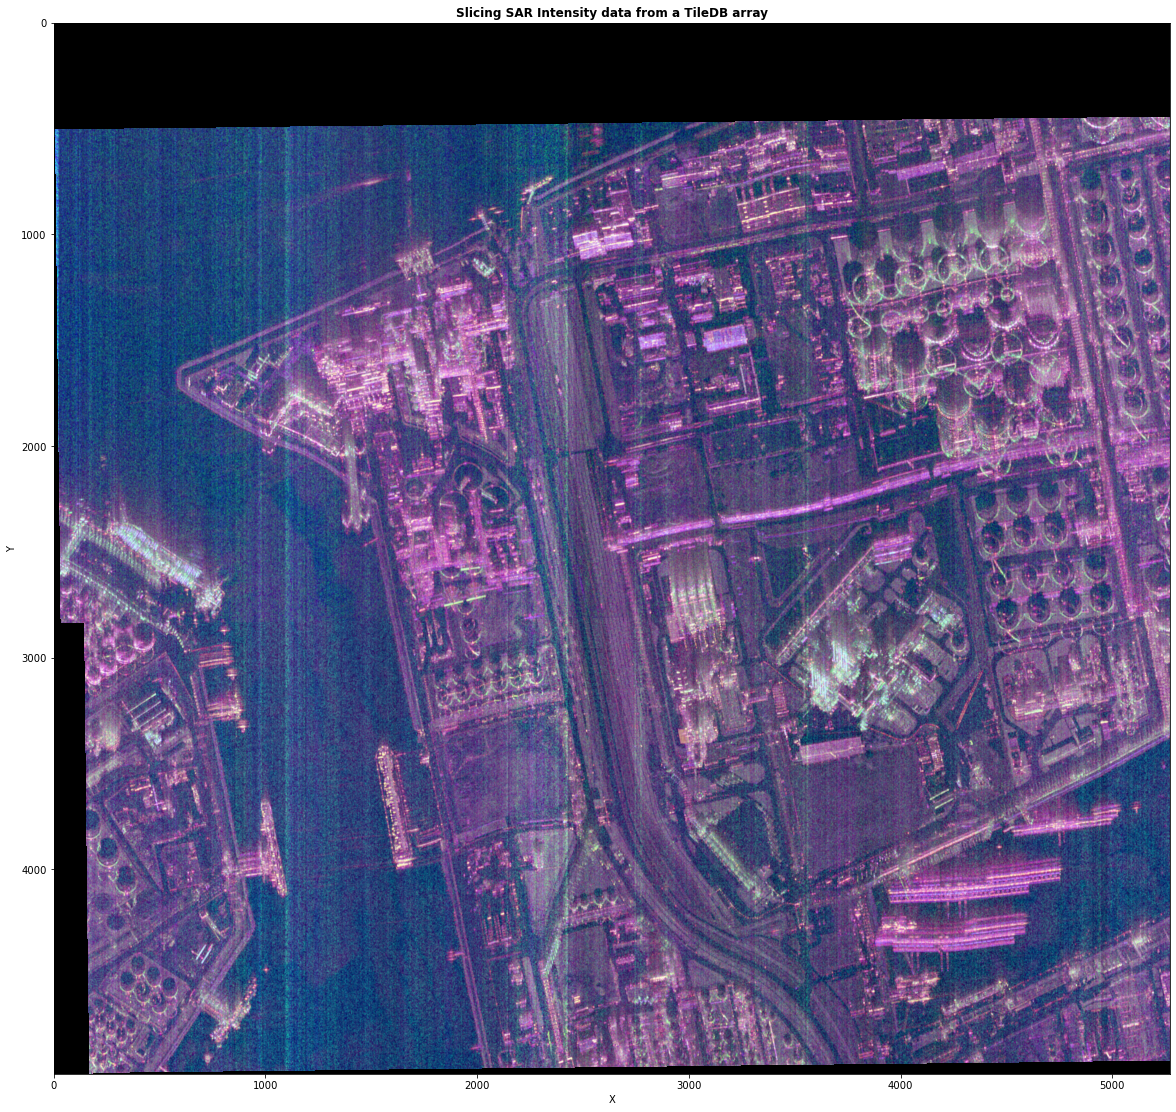

In [156]:
with rasterio.Env():
    with rasterio.open(output_array) as src:
        # query dataset in lat/lon coordinates
        native_bounds = transform_bounds(CRS.from_epsg(4326), src.crs, *lat_lon_bbox)        
        bounds_window = src.window(*native_bounds)
        bounds_window = bounds_window.intersection(Window(0, 0, src.width, src.height))

        img = src.read(("enter red and blue bands here"), window=bounds_window)
        print(f"window shape: {img.shape}\n")

        arr = reshape_as_raster(img)
        for b, band in enumerate(arr):
            arr[b] = adjust_band(band)
        arr = reshape_as_image(arr)
        arr = np.concatenate((arr[:1], gamma2, arr[1:]), axis=0)

        fig, ax = pyplot.subplots(1, 1, figsize=(20, 20))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        show(arr, ax=ax, title="Slicing SAR Intensity data from a TileDB array")